In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import time

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.grid_search import GridSearchCV
from sklearn.svm import SVC

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *



/Applications/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Applications/anaconda/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


## Prepare Train and Test Dataset

In [2]:
df = pd.read_csv("../labeled_dataAll.csv", index_col='ID')
df.head(5)

,Label_alpha,Label_num,Drug,Food,sentence
ID,,,,,
400,neutral,1,ACE inhibitor,pentadecanoic acid,(123)iodine labelled beta-methyl-iodophenyl pe...
333,positive,2,ACE inhibitor,2-phenylethanol,2-Phenylethanol is a widely used aroma compoun...
77,positive,2,ACE inhibitor,"3,4-dihydroxyphenylacetic acid","3,4-dihydroxyphenylacetic acid and 4-methylcat..."
338,neutral,1,ACE inhibitor,arachin,A 96-well microplate format of this method was...
214,neutral,1,ACE inhibitor,diethylamine,A biochemical study was performed in order to ...


In [3]:
# Shuffle and split 75/25 for training/testing

# Randomly shuffle the data. Use same random seed to get same results every time. 
df_shuffle = df.sample(frac=1, random_state=0).reset_index(drop=True)
n = len(df_shuffle.Drug)


# Split the train data into training and dev datasets
df_train =  df_shuffle[:3*n/4]
df_test = df_shuffle[3*n/4:]


In [4]:
print len(df_train)
print len(df_test)

1853
618


In [5]:
drugs = df.Drug.unique()
print drugs
add_dict = {}

for drug in drugs:
    
    count_list = []
    for i in range(3):
        count = len(df_train[(df_train.Drug == drug) & (df_train.Label_num == i)])
        count_list.append(count)
        
    max_count = max(count_list)
    add_list = [max(0,max_count-c) for c in count_list]
    add_dict[drug] = add_list


['ACE inhibitor' 'Antacid' 'GLP-1' 'Thyroxine' 'Statin' 'Acetaminophen'
 'Digoxin' 'Isoniazid' 'Antihistamine' 'MOAI' 'Analgesics'
 'Bronchodialators']


In [6]:
print add_dict

{'GLP-1': [86, 0, 39], 'Thyroxine': [48, 0, 63], 'MOAI': [26, 0, 0], 'Antihistamine': [16, 0, 6], 'Analgesics': [7, 2, 0], 'Digoxin': [86, 0, 97], 'Isoniazid': [28, 0, 34], 'Acetaminophen': [255, 0, 326], 'Statin': [149, 0, 128], 'Antacid': [20, 0, 14], 'Bronchodialators': [10, 0, 0], 'ACE inhibitor': [208, 0, 81]}


In [7]:
n_train_original = len(df_train)
print n_train_original

1853


In [8]:
for drug in drugs:
    for i in range(3):
        temp = df_train[(df_train.Drug == drug) & (df_train.Label_num == i)].sample(add_dict[drug][i], replace=True)
        df_train = df_train.append(temp)

print len(df_train)

3582


In [9]:
print sum([j for i in add_dict.values() for j in i]) + n_train_original

3582


In [10]:
# Randomly shuffle the data. Use same random seed to get same results every time. 
df_shuffle = df_train.sample(frac=1, random_state=0).reset_index(drop=True)

# Separate labels
labels = [i for i in df_shuffle.Label_num]
labels = np.array(labels)
n = len(labels)

labels2 = [i for i in df_test.Label_num]
labels2 = np.array(labels2)


# Drop unecessary columns from input data
df_shuffle.drop('Label_alpha', axis=1, inplace=True)
df_shuffle.drop('Label_num', axis=1, inplace=True)
df_shuffle.drop('Drug', axis=1, inplace=True)
df_shuffle.drop('Food', axis=1, inplace=True)

df_test.drop('Label_alpha', axis=1, inplace=True)
df_test.drop('Label_num', axis=1, inplace=True)
df_test.drop('Drug', axis=1, inplace=True)
df_test.drop('Food', axis=1, inplace=True)


# Split the train data into training and dev datasets
train_data =  df_shuffle[:3*n/4].sentence.tolist()
dev_data = df_shuffle[3*n/4:].sentence.tolist()
test_data = df_test.sentence.tolist()

# Separate training and dev labels
train_labels =  labels[:3*n/4]
dev_labels = labels[3*n/4:]
test_labels = labels2

In [11]:
print 'training label shape:', train_labels.shape
print 'test label shape:', test_labels.shape
print 'dev label shape:', dev_labels.shape

training label shape: (2686,)
test label shape: (618,)
dev label shape: (896,)


In [12]:
classes = ['negative', 'neutral', 'positive'] # corresponding labels = 0, 1, 2
classes_dict = {0:'negative', 1:'neutral', 2:'positive'} # corresponding labels = 0, 1, 2

In [13]:
def count_classes(value, labels):
    return len([i for i in labels if i == value])

In [14]:
# Check number of classes per train/dev/test dataset:
print "Dataset split among Negative, Neutral and Positive"

print "{0:>15} |{1:>15} |{2:>15} |{3:>15}".format("dataset","negative", "neutral", "positive")
print "{0:>15} |{1:>15f} |{2:>15f} |{3:>15f}".format("train",count_classes(0,train_labels), 
                                                     count_classes(1,train_labels),
                                                     count_classes(2,train_labels))
print "{0:>15} |{1:>15f} |{2:>15f} |{3:>15f}".format("dev",count_classes(0,dev_labels), 
                                                     count_classes(1,dev_labels),
                                                     count_classes(2,dev_labels))
print "{0:>15} |{1:>15f} |{2:>15f} |{3:>15f}".format("test",count_classes(0,test_labels), 
                                                     count_classes(1,test_labels),
                                                     count_classes(2,test_labels))

Dataset split among Negative, Neutral and Positive
        dataset |       negative |        neutral |       positive
          train |     885.000000 |     898.000000 |     903.000000
            dev |     309.000000 |     296.000000 |     291.000000
           test |     104.000000 |     389.000000 |     125.000000


In [15]:
# Check few sentences

def print_examples(num_examples=5):

    for i in range(num_examples):
        print "Training example", i+1
        print "Label", train_labels[i], "(", classes_dict[train_labels[i]],")"
        print "Sentence:\n", train_data[i], "\n\n"
       
    
print_examples(5)

Training example 1
Label 1 ( neutral )
Sentence:
Pharmaceutical compounds evaluated were nonsteroidal anti-inflammatory drugs (acetaminophen, diclofenac, ibuprofen, ketoprofen, naproxen and salicylic acid), antibiotics (sulfamethoxazole and trimethoprim), an anti-epileptic drug (carbamazepine), a beta-blocker (propranolol), a nervous stimulant (caffeine), estrogens (17alpha-ethinylestradiol, 17beta-estradiol, estriol and estrone) and lipid regulators (clofibric acid, metabolite of clofibrate and gemfibrozil). 


Training example 2
Label 1 ( neutral )
Sentence:
Rice, parboiled rice, finger millet, germinated finger millet, broken wheat, njavara (medicinal rice), sorghum and maize were used as substrates for solid state fermentation of Monascus purpureus at 28C for 7 days using 2% seed medium as inoculum for the production of its metabolites. 


Training example 3
Label 0 ( negative )
Sentence:
Treatment with 200 M L-DOPA significantly increased death-related signaling proteins, while co

# Logistic Regression Model

In [16]:
# Turn the raw training text into feature vectors based on "td-idf"
vectorizer = TfidfVectorizer()
vocab_train_tf = vectorizer.fit_transform(train_data)
vocab_dev_tf = vectorizer.transform(dev_data)

In [17]:
import time
# Logistic Regression:
print "Evaluating Logistic Regression model ..."

# Create a Logistic Regression model. 
LRmodel = LogisticRegression(C=1.0)

# Create a grid search.
print "Performing grid search for Logistic Regression model. It may take a few minutes ..."
Cs = {'C': [0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0, 20.0, 50.0, 100.0]}
CV_LRmodel = GridSearchCV(estimator=LRmodel, param_grid=Cs)

# Fit the models using grid search and display the results.
start_time = time.time()
CV_LRmodel.fit(vocab_train_tf, train_labels)
end_time = time.time()
print "Logistic Regression grid search model fitting time = %f seconds." % (end_time - start_time)

optimal_Cs = CV_LRmodel.best_params_['C']
print "As per the grid search on the training data, the optimal value of C = %f." % optimal_Cs

# Construct model with optimal C
model_LR = LogisticRegression(C=optimal_Cs)
model_LR.fit(vocab_train_tf, train_labels)
    

Evaluating Logistic Regression model ...
Performing grid search for Logistic Regression model. It may take a few minutes ...
Logistic Regression grid search model fitting time = 0.915961 seconds.
As per the grid search on the training data, the optimal value of C = 10.000000.


LogisticRegression(C=10.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

# Dev Data

Dev dataset with 896 sentences

Data split - Negative, Neutral, Positive
----------------------------------------
        dataset |       negative |        neutral |       positive
  dev_predicted |     324.000000 |     291.000000 |     281.000000
     dev_actual |     309.000000 |     296.000000 |     291.000000

Accuracy
--------
Accuracy (test data): 0.900

Classification Report
---------------------
             precision    recall  f1-score   support

          0       0.94      0.98      0.96       309
          1       0.87      0.86      0.87       296
          2       0.88      0.85      0.87       291

avg / total       0.90      0.90      0.90       896


Confusion matrix for Dev data
-----------------------------
The most confused pair of classes is: 2 ( positive )  incorrectly predicted as 1 ( neutral )
Number of such confusion occurences: 35


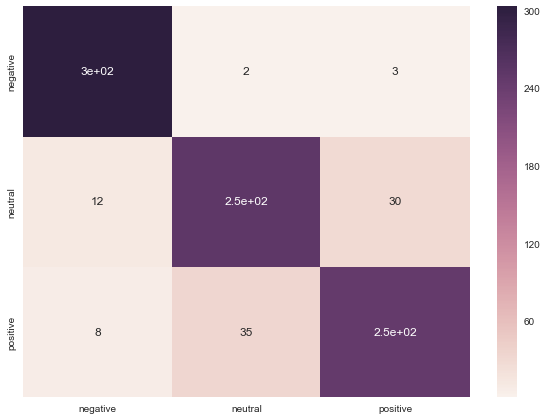

In [18]:
# Validation data
predicted_labels_LR = model_LR.predict(vocab_dev_tf)

print "Dev dataset with", len(predicted_labels_LR), "sentences"
print ""

print "Data split - Negative, Neutral, Positive"
print "----------------------------------------"
print "{0:>15} |{1:>15} |{2:>15} |{3:>15}".format("dataset","negative", "neutral", "positive")
print "{0:>15} |{1:>15f} |{2:>15f} |{3:>15f}".format("dev_predicted",count_classes(0,predicted_labels_LR), 
                                                     count_classes(1,predicted_labels_LR),
                                                     count_classes(2,predicted_labels_LR))
print "{0:>15} |{1:>15f} |{2:>15f} |{3:>15f}".format("dev_actual",count_classes(0,dev_labels), 
                                                     count_classes(1,dev_labels),
                                                     count_classes(2,dev_labels))


accuracy = model_LR.score(vocab_dev_tf, dev_labels)
print "\nAccuracy"
print "--------"
print "Accuracy (test data): %.3f" %(accuracy)

print "\nClassification Report"
print "---------------------"
print classification_report(dev_labels, predicted_labels_LR)

print "\nConfusion matrix for Dev data"
print "-----------------------------"

array = confusion_matrix(dev_labels, predicted_labels_LR)
df_cm = pd.DataFrame(array, index = ["negative", "neutral", "positive"],
                  columns = ["negative", "neutral", "positive"])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

# Find the most confused pair
cm2 = confusion_matrix(dev_labels, predicted_labels_LR)  # copy the cm matrix so that can modify the copy without affecting original cm
np.fill_diagonal(cm2, 0)  # set the values in the diagonal = 0 to obtain number of confused pairs matrix
maximum_pair_idx = np.where(cm2 == cm2.max())  # returns the indices of the max value in cm matrix
true_interaction = maximum_pair_idx[0][0]
predicted_interaction = maximum_pair_idx[1][0]
max_wrong_prediction = cm2[true_interaction][predicted_interaction]
print "The most confused pair of classes is:", true_interaction, "(", classes_dict[true_interaction],")",\
" incorrectly predicted as", predicted_interaction, "(", classes_dict[predicted_interaction],")"
print "Number of such confusion occurences:", max_wrong_prediction

## Test data

Test dataset with 618 sentences

Data split - Negative, Neutral, Positive
----------------------------------------
        dataset |       negative |        neutral |       positive
 test_predicted |      92.000000 |     402.000000 |     124.000000
    test_actual |     104.000000 |     389.000000 |     125.000000

Accuracy
--------
Accuracy (test data): 0.728

Classification Report
---------------------
             precision    recall  f1-score   support

          0       0.59      0.52      0.55       104
          1       0.82      0.84      0.83       389
          2       0.55      0.54      0.55       125

avg / total       0.72      0.73      0.73       618


Confusion matrix for test data
------------------------------
The most confused pair of classes is: 2 ( positive )  incorrectly predicted as 1 ( neutral )
Number of such confusion occurences: 45


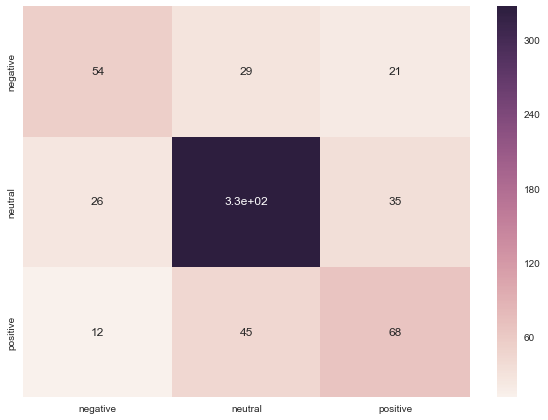

In [19]:
# Test data

vocab_test_tf = vectorizer.transform(test_data)
predicted_labels_LR2 = model_LR.predict(vocab_test_tf)
print "Test dataset with", len(predicted_labels_LR2), "sentences"
print ""

print "Data split - Negative, Neutral, Positive"
print "----------------------------------------"
print "{0:>15} |{1:>15} |{2:>15} |{3:>15}".format("dataset","negative", "neutral", "positive")
print "{0:>15} |{1:>15f} |{2:>15f} |{3:>15f}".format("test_predicted",count_classes(0,predicted_labels_LR2), 
                                                     count_classes(1,predicted_labels_LR2),
                                                     count_classes(2,predicted_labels_LR2))
print "{0:>15} |{1:>15f} |{2:>15f} |{3:>15f}".format("test_actual",count_classes(0,test_labels), 
                                                     count_classes(1,test_labels),
                                                     count_classes(2,test_labels))

accuracy = model_LR.score(vocab_test_tf, test_labels)
print "\nAccuracy"
print "--------"
print "Accuracy (test data): %.3f" %(accuracy)

print "\nClassification Report"
print "---------------------"
print classification_report(test_labels, predicted_labels_LR2)


print "\nConfusion matrix for test data"
print "------------------------------"

array = confusion_matrix(test_labels, predicted_labels_LR2)
df_cm = pd.DataFrame(array, index = ["negative", "neutral", "positive"],
                  columns = ["negative", "neutral", "positive"])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)


# Find the most confused pair
cm3 = confusion_matrix(test_labels, predicted_labels_LR2)  # copy the cm matrix so that can modify the copy without affecting original cm
np.fill_diagonal(cm3, 0)  # set the values in the diagonal = 0 to obtain number of confused pairs matrix
maximum_pair_idx = np.where(cm3 == cm3.max())  # returns the indices of the max value in cm matrix
true_interaction = maximum_pair_idx[0][0]
predicted_interaction = maximum_pair_idx[1][0]
max_wrong_prediction = cm3[true_interaction][predicted_interaction]
print "The most confused pair of classes is:", true_interaction, "(", classes_dict[true_interaction],")",\
" incorrectly predicted as", predicted_interaction, "(", classes_dict[predicted_interaction],")"
print "Number of such confusion occurences:", max_wrong_prediction

# Analysis of Errors

## 1. Words with the highest weights per class

In [20]:
vectorizer = TfidfVectorizer()
vocab_train = vectorizer.fit_transform(train_data)
feature_names = vectorizer.get_feature_names()

model_LR = LogisticRegression(C=optimal_Cs)
model_LR.fit(vocab_train, train_labels)

weights = model_LR.coef_   # weight vector for each label
top30_features_index = []  # list of 30 features (10 words with the largest weights for each label)
class_list = ['negative', 'neutral', 'positive']

for i in range(3):  # 4 labels
    weights_label_i = list(weights[i])  # list of weights for label i
    top10_weights_label_i = sorted(weights_label_i, reverse=True)[0:10]  # sort and filter greatest 10 weights
    top10_features_index_i = [weights_label_i.index(weight) \
                             for weight in top10_weights_label_i]  # find index of top 10
    top10_features_i = [feature_names[index] for index in top10_features_index_i]  # list of features of top 10 weights
    top30_features_index += top10_features_index_i  # add the top 10 weigths index of label i to the list of 30

    # Print top 5 features per label
    print "Class", i, "(", class_list[i] , ")"
    for index, (weight, feature) in enumerate(zip(top10_weights_label_i,top10_features_i), start = 1):
        print index, "weight: %.3f" %(weight), "for feature \"", feature, "\""

top30_features = [feature_names[index] for index in top30_features_index]  # list of features of top 20 weights

# Formatting weights for each class for printing table of results
top30_w_class0 = ["%.3f" %(list(weights[0])[index]) for index in top30_features_index]
top30_w_class1 = ["%.3f" %(list(weights[1])[index]) for index in top30_features_index]
top30_w_class2 = ["%.3f" %(list(weights[2])[index]) for index in top30_features_index]



weights_array = np.column_stack((top30_w_class0, top30_w_class1, top30_w_class2))

# Print table of weights for the 20 top features
print "\nTable of weights for each feature for each of the 3 labels:\n"
row_format ="{:>20}" * (len(class_list) + 1)
print row_format.format("", *class_list)
for feature, weights in zip(top30_features, weights_array):
    print row_format.format(feature, *weights)


Class 0 ( negative )
1 weight: 7.902 for feature " induced "
2 weight: 5.251 for feature " acetylneuraminic "
3 weight: 5.156 for feature " inhibited "
4 weight: 4.964 for feature " stimulated "
5 weight: 4.323 for feature " hepatotoxicity "
6 weight: 4.152 for feature " treatment "
7 weight: 3.928 for feature " breads "
8 weight: 3.918 for feature " protect "
9 weight: 3.894 for feature " consumption "
10 weight: 3.845 for feature " reduced "
Class 1 ( neutral )
1 weight: 7.056 for feature " study "
2 weight: 4.796 for feature " were "
3 weight: 4.752 for feature " on "
4 weight: 3.806 for feature " mouse "
5 weight: 3.759 for feature " studied "
6 weight: 3.751 for feature " investigated "
7 weight: 3.714 for feature " not "
8 weight: 3.683 for feature " evaluated "
9 weight: 3.350 for feature " no "
10 weight: 3.043 for feature " sodium "
Class 2 ( positive )
1 weight: 6.027 for feature " enhanced "
2 weight: 5.169 for feature " inhibitory "
3 weight: 4.559 for feature " red "
4 wei

** Observations **  
**BEFORE** bootstrapping:
1. Some neutral prediction words seem promising, in particular, "study", "investigated", "studied"
2. Some negative and positive prediciton words seem helpful
3. Main weakness of the model: this is a bag of word model with feature based on tf-idf. Thus, a drug name or food compound can also result with an important weight to predict a class and this is misleading. For example, "monoamine" has a high weight for class "positive" based on the positive labels of sentences containing this word. Thus, even if we will add a sentence with a negative interaction between monoamine and a food compound, the BOW model will predict a positive label. The proportion of labels for a drug-food interaction sentences in the training will affect how the model will retain those drugs or food compounds as predictors of positive/negative/neutral. 

**AFTER** bootstrapping:
similar to above but seems to have less drug and food related words with high weight for predicting label

## 2. R-ratio analysis - look at individual sentences with highest errors

R is equal to maximum predicted probability divided by predicted probability of the correct label.  
In other words, it looks how "far" the prediction of a class is from the true class.


In [21]:
vectorizer = TfidfVectorizer()
vocab_train_tf = vectorizer.fit_transform(train_data)
vocab_test_tf = vectorizer.transform(test_data)
feature_names = vectorizer.get_feature_names()

# Logistic regression model with optimal C
model_LR = LogisticRegression(C=optimal_Cs)
model_LR.fit(vocab_train_tf, train_labels)
predicted_labels_LR = model_LR.predict(vocab_test_tf)

#feature_names = vectorizer.get_feature_names()
#print "features names length:", len(feature_names)

    
# Variables to calculate R
probabilities = model_LR.predict_proba(vocab_test_tf)  # Each label probability (4) for each document
proba_max = probabilities.max(axis=1)  # Maximum predicted probability
proba_correct_label = [probabilities[i][test_labels[i]] \
                       for i in range(probabilities.shape[0])]  # Predicted prob of the correct label
r_ratio = proba_max/proba_correct_label  # R = maximum predicted prob / predicted prob of the correct label
sentence_index = [i for i in range(probabilities.shape[0])]  # Index of the document to retrace once sorted by R

# Results array with 5 columns (R, max prob, prob of correct label, predicted labels, true labels,
# document index)
results = np.column_stack((r_ratio, proba_max, proba_correct_label, predicted_labels_LR, \
                           test_labels, sentence_index))
results_max3r = sorted(results, key=lambda x: x[0], reverse=True)[:10]  # top 10 sentences with highest R


# Format and print top 3 documents with highest R:
# 1) print top 10 sentences related info - probabilities, predicted/correct labels, etc.
print "\nTop 10 sentences where the ratio R is largest:\n"
column_names = ["ratio R", "Max pred Pr", "Correct Pr", "Predicted label", "True label", \
                "Doc Index"]
row_format ="{:>16}" * (len(column_names)+1)
print row_format.format("", *column_names)
top_10 = ["Highest R", "2nd highest", "3rd highest", "4th", "5th", "6th", "7th", "8th", "9th", "10th"]
for index, row in zip(top_10, results_max3r):
    row = [round(item,3) for item in row]
    print row_format.format(index, *row)

# 2) print top 3 R documents messages
print "\nSentences:"
i = 1
for row in results_max3r:
    print "\n" + str(i) +") Sentence with ratio R = %.3f" %(row[0]), ":"
    print test_data[int(row[5])]
    i +=1  


# Diagnosis of influential words in the 3 documents with highest R
weights = model_LR.coef_
sentence_list = [int(result[5]) for result in results_max3r]
j=1

for example in sentence_list:
    predicted_label = predicted_labels_LR[example]
    indices = vocab_test_tf[example].indices  # list of indices of non zero features of document
    vocab_freq = vocab_test_tf[example].data  # list of features values of document
    weights_example = [weights[predicted_label][index] for index in indices]  # list of LR weights 
                                                                              # for non zero features of doc
    feature_importance = vocab_freq * weights_example  # feature value x weight for total influence on prediction

    features_array = np.column_stack((feature_importance, indices))
    features_sorted = sorted(features_array, key=lambda x: x[0], reverse=True)  # Sort words by influence

    # Print top 5 features (words) of the document with heaviest weight x value
    
    print "\nSentence", j,  "(example number", example, "):"
    for i in range(5):
        index = int(features_sorted[i][1])
        print "Influential word:", feature_names[index] ,"with magnitude:", features_sorted[i][0]
    j +=1


Top 10 sentences where the ratio R is largest:

                         ratio R     Max pred Pr      Correct Pr Predicted label      True label       Doc Index
       Highest R          76.185           0.898           0.012             1.0             2.0           428.0
     2nd highest          51.776            0.53            0.01             2.0             0.0            91.0
     3rd highest           47.84           0.927           0.019             1.0             0.0            30.0
             4th          44.444            0.79           0.018             2.0             0.0           337.0
             5th          43.047           0.809           0.019             2.0             0.0           435.0
             6th          40.012           0.935           0.023             2.0             1.0           360.0
             7th          37.808            0.55           0.015             0.0             1.0           587.0
             8th           25.24            0.7

# Model Improvement

In [48]:
## 1. Preprocessor

In [26]:
def empty_preprocessor(s):
    return s

def better_preprocessor(s):
    s = s.lower()  # to lowercase all letters in the string
    s = re.sub("[^a-zA-Z0-9]", " ", s) # to remove non-letter and non-numerical characters
    s = re.sub ('\d+', " numsequence ",s)  # replace sequences of numbers with a single token
    
    pronoun_list = ['you', 'he', 'she', 'we', 'they', 'me', 'him', 'his', 'her', 'hers', 'yours', 'us', 'our'\
                   'ours', 'their', 'theirs']  # list of pronouns as stopwords since not informative for prediciton
    for word in pronoun_list:
        s = re.sub(r'\b%s\b' % word, " ",s)  # to remove stopwords in the list
        
    nothelping = ['or', 'to', 'of', 'a', 'on', 'the']
    for word in nothelping:
        s = re.sub(r'\b%s\b' % word, " ",s)  # to remove stopwords in the list
        
    #s = re.sub(r'ly\b', "",s)   # to remove "ly" from words ending by "ly"
    s = re.sub(r'ing\b', "",s)  # to remove "ing" from words ending by "ing"
    #s = re.sub(r's\b', "",s)    # to remove "s" from words ending by "s"
    
    for word in s.split():  # to shorten words longer than 15 characters (from histogram, most words < 15)
        if len(word)>15:
            short_word = word[:15]
            s = s.replace(word,short_word)
    
    return s

In [27]:
# No preprocessor
vectorizer_initial = TfidfVectorizer()
vocab_train_initial = vectorizer_initial.fit_transform(train_data)
vocab_test_initial = vectorizer_initial.transform(test_data)
count_features_init = len(vectorizer_initial.get_feature_names())
print "Size of vocabulary with no preprocessor:", count_features_init

model_LR_initial = LogisticRegression(C=optimal_Cs)
model_LR_initial.fit(vocab_train_initial, train_labels)
predicted_labels_initial = model_LR_initial.predict(vocab_test_initial)
accuracy_initial = model_LR_initial.score(vocab_test_initial, test_labels)
print "accuracy with no custom preprocessor is: %.3f" %(accuracy_initial)
print ""


# With preprocessor
vectorizer_better = TfidfVectorizer(preprocessor=better_preprocessor)
vocab_train_better = vectorizer_better.fit_transform(train_data)
vocab_test_better = vectorizer_better.transform(test_data)

count_features_better = len(vectorizer_better.get_feature_names())
print "Size of vocabulary with custom preprocessor:", count_features_better

model_LR_better = LogisticRegression(C=optimal_Cs)
model_LR_better.fit(vocab_train_better, train_labels)
predicted_labels_better = model_LR_better.predict(vocab_test_better)
accuracy_better = model_LR_better.score(vocab_test_better, test_labels)
print "accuracy with custom preprocessor is: %.3f" %(accuracy_better)

Size of vocabulary with no preprocessor: 8435
accuracy with no custom preprocessor is: 0.728

Size of vocabulary with custom preprocessor: 7778
accuracy with custom preprocessor is: 0.715


In [29]:
# Preprocessor not helping....

## 2. N-grams instead of unigrams

In [28]:
# Turn the raw training text into feature vectors based on "td-idf"
vectorizer = TfidfVectorizer(analyzer='char' , ngram_range=(5,8))
vocab_train_tf = vectorizer.fit_transform(train_data)
vocab_dev_tf = vectorizer.transform(dev_data)

# Logistic regression model
model_LR = LogisticRegression(C=optimal_Cs)
model_LR.fit(vocab_train_tf, train_labels)
predicted_labels_LR_ngram = model_LR.predict(vocab_dev_tf)

accuracy = model_LR.score(vocab_dev_tf, dev_labels)
print "Accuracy (dev data): %.3f" %(accuracy)

vocab_test_tf = vectorizer.transform(test_data)
predicted_labels_LR_ngram2 = model_LR.predict(vocab_test_tf)
accuracy = model_LR.score(vocab_test_tf, test_labels)
print "Accuracy (test data): %.3f" %(accuracy)

Accuracy (dev data): 0.916
Accuracy (test data): 0.731
